In [1]:
import os, shutil
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.models import model_from_json
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import numpy as np
import matplotlib.pyplot as plt
import colorama
from colorama import Fore, Style

In [2]:
MAINPATH="C:/Users/Harshit/Downloads/PIeChart_Data_Extraction_C3/PIeChart_Data_Extraction/MINI-Project/MINI-Project"

In [3]:
TEST_DIR = MAINPATH+ "/test"
MODEL_DIR = MAINPATH+ "/VGG-19"
OUTPUT_DIR = MAINPATH+ "/barplots"
dir2= MAINPATH+ "/piechart"
CSV=MAINPATH+"/test.csv"

In [4]:
import os, csv
if os.path.isfile(CSV):
    print ("File already exist")
    f = open(CSV, 'r+')
    f.truncate(0)
else:
    print ("File created")
    f=open(CSV,'a')
w=csv.writer(f)
w.writerow("c")    
for path, dirs, files in os.walk(TEST_DIR):
    for filename in files:
        print(filename)
        w.writerow([filename])
        
f.close()

File already exist
2.jpg
3d4.png
3n4.png
chart2.png
p.png
pi.png


In [5]:
testdf = pd.read_csv(CSV)

test_datagen = ImageDataGenerator(rescale=1./255.)

test_generator = test_datagen.flow_from_dataframe(
    dataframe = testdf,
    directory = TEST_DIR,
    x_col = "c",
    y_col = None,
    batch_size = 1,
    seed = 42,
    shuffle = False,
    class_mode = None,
    target_size = (224, 224))

Found 6 validated image filenames.


In [6]:
json_file = open(MODEL_DIR+ "/model.json", 'r')
loaded_model_json = json_file.read()
json_file.close()

loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights(MODEL_DIR+ "/model.h5")
print("Loaded model from disk")

Loaded model from disk


In [7]:
test_generator.reset()
STEP_SIZE_TEST=test_generator.n // test_generator.batch_size

pred = loaded_model.predict(test_generator,
                            steps=STEP_SIZE_TEST,
                            verbose=1)

predicted_class_indices = np.argmax(pred, axis=1)

6/6 [==============================] - 3s 381ms/step


In [8]:
class_indices = {'AreaGraph': 0,
 'BarGraph': 1,
 'BoxPlot': 2,
 'BubbleChart': 3,
 'FlowChart': 4,
 'LineGraph': 5,
 'Map': 6,
 'NetworkDiagram': 7,
 'ParetoChart': 8,
 'PieChart': 9,
 'ScatterGraph': 10,
 'TreeDiagram': 11,
 'VennDiagram': 12}

labels = class_indices
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

filenames = test_generator.filenames
results = pd.DataFrame({"chart": filenames, "type": predictions})

In [9]:
barplots = results.loc[results['type'] == 'BarGraph']
barplotlist = barplots['chart'].tolist()

In [10]:
piechart = results.loc[results['type'] == 'PieChart']
piechartlist = piechart['chart'].tolist()

In [11]:
if not os.path.exists(OUTPUT_DIR):
    os.mkdir(OUTPUT_DIR)
    
for file in os.listdir(TEST_DIR):
    if file in barplotlist:
        shutil.copy(os.path.join(TEST_DIR, file), OUTPUT_DIR)

In [12]:
if not os.path.exists(dir2):
    os.mkdir(dir2)
    
for file in os.listdir(TEST_DIR):
    if file in piechartlist:
        shutil.copy(os.path.join(TEST_DIR, file), dir2)

In [13]:
import webcolors
import os, shutil
import numpy as np
import pandas as pd
import tensorflow as tf
from colorama import Fore, Style
from PIL import Image
import cv2
import time
start = time.time()
def closest_colour(requested_colour):
    min_colours = {}
    for key, name in webcolors.CSS3_HEX_TO_NAMES.items():
        r_c, g_c, b_c = webcolors.hex_to_rgb(key)
        rd = (r_c - requested_colour[0]) ** 2
        gd = (g_c - requested_colour[1]) ** 2
        bd = (b_c - requested_colour[2]) ** 2
        min_colours[(rd + gd + bd)] = name
    return min_colours[min(min_colours.keys())]

def get_colour_name(requested_colour):
    try:
        closest_name = actual_name = webcolors.rgb_to_name(requested_colour)
    except ValueError:
        closest_name = closest_colour(requested_colour)
        actual_name = None
    return actual_name, closest_name


In [14]:
def colored(r, g, b, text):
    return "\033[38;2;{};{};{}m{} \033[38;2;255;255;255m".format(r, g, b, text)


In [15]:
import math 
def dis(x1,y1,x2,y2):
   return math.sqrt((x1-x2)*(x1-x2)+(y1-y2)*(y1-y2))

In [16]:
import cv2
def click_event(event, x, y, flags, params):
 
    # checking for left mouse clicks
    if event == cv2.EVENT_LBUTTONDOWN:
 
        # displaying the coordinates
        # on the Shell
        global mp
        mp = np.array([[np.float32(x)], [np.float32(y)]])
        cv2.destroyAllWindows()

In [17]:
def connected_component_label(path):
    global mp
    color=[]
    mp = np.array((2, 1), np.float32)
    # Getting the input image
    img = cv2.imread(path, 0)
    # Converting those pixels with values 1-127 to 0 and others to 1
    img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY)[1]
    connectivity = 8
    output = cv2.connectedComponentsWithStats(img, connectivity, cv2.CV_32S)
    num_labels = output[0]
    #print(num_labels)
    labels = output[1]
    stats = output[2]
    centroids =output[3]
    cv2.imshow('Mark_center_of_piechart', img)
    cv2.setMouseCallback('Mark_center_of_piechart', click_event)
    
    # wait for a key to be pressed to exit
    cv2.waitKey(0)
    xc=int(mp[0])
    yc=int(mp[1])
    sumn=0
    count=0
    mean=np. mean(centroids)
    # print(centroids)
    # print(mean)
    x=np.array(output[2][1:,cv2.CC_STAT_AREA])
    wx=np.array(output[2][1:,cv2.CC_STAT_WIDTH])
    hx=np.array(output[2][1:,cv2.CC_STAT_HEIGHT])
    tx=np.array(output[2][1:,cv2.CC_STAT_TOP])
    lx=np.array(output[2][1:,cv2.CC_STAT_LEFT])
    height=stats[0, cv2.CC_STAT_HEIGHT]/2.5
    sum=0
    sumx=0
    sumy=0
    src2=cv2.cvtColor(src, cv2.COLOR_RGB2BGR)
    for idx,value in enumerate(x):
      if idx==0 or value<100:
        continue
      #########
      h=hx[idx]
      w=wx[idx]
      if w/3>h:
        continue
      xi=int(centroids[idx+1][0])
      yi=int(centroids[idx+1][1])
      ######
      dist=dis(xc,yc,xi,yi)
      sumn=sumn+dist
      count=count+1
    meann=sumn/count 
    cnt=0
    for idx,value in enumerate(x):
      if idx==0 or value<100:
        continue
      h=hx[idx]
      w=wx[idx]
      if w/3>h:
        continue
      xi=int(centroids[idx+1][0])
      yi=int(centroids[idx+1][1])
      # print(xi," ",yi)
      sumx=sumx+xi
      sumy=sumy+yi
      d=dis(xi,yi,xc,yc)
      #print(xi,yi,d,xc,yc)
      if d<height:
        cnt=cnt+1
      else :
        #print("3d")
        continue
      sum=sum+value
    cnt=0
    for idx,value in enumerate(x):
      if idx==0 or value<100:
        continue
      #########
      h=hx[idx]
      w=wx[idx]
      if w/3>h:
        continue
      xi=int(centroids[idx+1][0])
      yi=int(centroids[idx+1][1])
      sumx=sumx+xi
      sumy=sumy+yi
      d=0
      d=dis(xi,yi,xc,yc)
      if d<height:
        cnt=cnt+1
      else :
        continue
      b = src2[yi,xi, 0]
      g = src2[yi,xi, 1]
      r = src2[yi,xi, 2]
      color.append(tuple([r,g,b,xi,yi]))
      requested_colour=[b,g,r]
      actual_name, closest_name = get_colour_name(requested_colour)
      colored_text=colored(b,g,r,closest_name);
      print(colored_text,end=" ")
      print(Style.RESET_ALL,end="")
      print(" Percentage : ",value/sum*100)
    
    # Map component labels to hue val, 0-179 is the hue range in OpenCV
    label_hue = np.uint8(179*labels/np.max(labels))
    blank_ch = 255*np.ones_like(label_hue)
    labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])

    # Converting cvt to BGR
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)

    # set bg label to black
    labeled_img[label_hue==0] = 0
    
    # Showing Original Image
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title("Orginal Image")
    plt.show()
    
    #Showing Image after Component Labeling
    for c in color:
      nb = labeled_img[c[4],c[3], 2]
      ng = labeled_img[c[4],c[3], 1]
      nr = labeled_img[c[4],c[3], 0]
      labeled_img[np.all(labeled_img==(nr,ng,nb),axis=-1)]=(c[0],c[1],c[2])
    labeled_img=cv2.cvtColor(labeled_img, cv2.COLOR_BGR2RGB)
    nb = labeled_img[2,2, 2]
    ng = labeled_img[2,2, 1]
    nr = labeled_img[2,2, 0]
    labeled_img[np.all(labeled_img==(nr,ng,nb),axis=-1)]=(255,255,255)
    labeled_img[np.all(labeled_img==(0,0,0),axis=-1)]=(255,255,255)
    cv2.imwrite(MAINPATH+"/labeled_output.png",labeled_img)
    plt.imshow(labeled_img)
    plt.axis('off')
    plt.title("Image after Component Labeling")
    plt.show()


In [18]:
import cv2
import numpy
import glob
print
cv_img = []
file=os.listdir(dir2)
pattern = "*.png , *.jpg"
img_path= dir2+"/"+file[1]
print(img_path)
src = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
#cv2.imshow("v",src)
src = cv2.GaussianBlur(src, (3, 3), 0)

C:/Users/Harshit/Downloads/PIeChart_Data_Extraction_C3/PIeChart_Data_Extraction/MINI-Project/MINI-Project/piechart/3d4.png


In [19]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
img = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
lap = cv2.Laplacian(img, cv2.CV_64F, ksize=3)
lap = np.uint8(np.absolute(lap))
sobelX = cv2.Sobel(img, cv2.CV_64F, 0, 1)
sobelY = cv2.Sobel(img, cv2.CV_64F, 1, 0)
sobelX = np.uint8(np.absolute(sobelX))
sobelY = np.uint8(np.absolute(sobelY))
sobelCombined = cv2.bitwise_or(sobelX, sobelY)
titles = ['image', 'Laplacian', 'sobelX', 'sobelY', 'sobelCombined']
images = [img, lap, sobelX, sobelY, sobelCombined]
cv2.imwrite(MAINPATH+"/sobelcombined.png",sobelCombined)

True

In [20]:
_, thresh = cv2.threshold(sobelCombined,10,255,cv2.THRESH_BINARY) 
cv2.imwrite(MAINPATH+"/threshed.png",thresh)


True

In [21]:
def undesired_objects (image):
    image = image.astype('uint8')
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(image, connectivity=8)
    sizes = stats[:, -1]

    max_label = 1
    max_size = sizes[1]
    for i in range(2, nb_components):
        if sizes[i] > max_size:
            max_label = i
            max_size = sizes[i]

    img2 = np.zeros(output.shape)
    img2[output == max_label] = 255
    #cv2.imshow("Undesired_removed",img2)
    cv2.imwrite(MAINPATH+"/undesired_removed.jpg",img2)
    
    cv2.waitKey()
    return img2

In [22]:
from skimage.morphology import skeletonize
thinned=cv2.ximgproc.thinning(thresh,thinningType=cv2.ximgproc.THINNING_GUOHALL) 
#cv2.imshow("thinned",thinned) 
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3)) 
new=undesired_objects(thinned) 
#cv2.imshow("largest connected component",new) 
dilate=cv2.dilate(new,kernel, iterations=1)
#cv2.imshow("dilated",dilate)
cv2.imwrite(MAINPATH+"/dilate.png",dilate)
ret, thresh2 = cv2.threshold(dilate, 150, 255, cv2.THRESH_BINARY_INV)
#cv2.imshow("binary_inverted",thresh2)
cv2.imwrite(MAINPATH+"/threshed.png",thresh2)
src_ = cv2.imread('new.png', cv2.IMREAD_UNCHANGED)

darkorchid   Percentage :  9.940711462450592
cornflowerblue   Percentage :  15.33596837944664
darkseagreen   Percentage :  24.150197628458496
orangered   Percentage :  20.968379446640316
darkorange   Percentage :  29.604743083003953


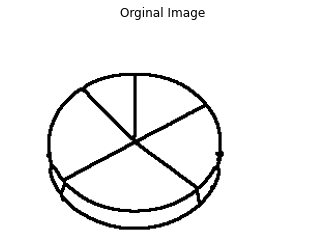

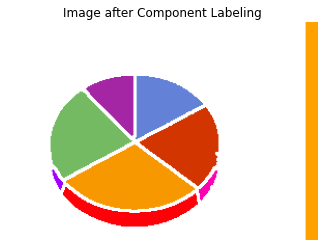

In [23]:
connected_component_label(MAINPATH+"/threshed.png")
